In [22]:
"""
Utilities for ergodicity experiments with random signals.
Data layout convention used in this notebook:
    - Row index: realization index.
    - Column index: time sample index.
"""
import matplotlib.pyplot as plt
import torch
import numpy as np
# Shared figure size [inches] so process and diagnostics panels are directly comparable.
COMMON_DIAGNOSTIC_FIGSIZE_IN: tuple[float, float] = (20.0, 10.0)
# Generate an ensemble matrix where each row is a realization and each column is a time sample.
def get_random_signals(
    num_realizations: int = 64,                    # Number of independent realizations (rows)
    num_samples: int = 1024,                       # Number of samples per realization (columns) [samples]
    mean: float = 0.0,                             # Gaussian mean for each sample
    std: float = 1.0,                              # Gaussian standard deviation for each sample
    seed: int | None = None,                       # Optional local seed for deterministic reproducibility
    generator: torch.Generator | None = None,      # Optional pre-configured RNG generator
    device: torch.device | str | None = None,      # Target device for generated samples
    dtype: torch.dtype = torch.float32,            # Floating dtype for generated samples
) -> torch.Tensor:                                 # Matrix with shape (num_realizations, num_samples)
    """
    Creates an ensemble of i.i.d. Gaussian signals for ergodicity analysis.
    Purpose:
        Build the random-signal matrix used to compare ensemble averages
        (across rows) with time averages (across columns).
    Parameters:
        num_realizations: Number of independent realizations (rows), must be > 0.
        num_samples: Number of samples per realization (columns) [samples], must be > 0.
        mean: Mean of the Gaussian distribution for each sample.
        std: Standard deviation of the Gaussian distribution; must be strictly positive.
        seed: Optional local seed. When provided, a local `torch.Generator` is created.
        generator: Optional generator used by `torch.randn`. Must not be combined with `seed`.
        device: Optional output device. Defaults to CPU when omitted.
        dtype: Output floating-point dtype. Defaults to `torch.float32`.
    Returns:
        torch.Tensor with shape (num_realizations, num_samples), where entry (i, k)
        is sample k from realization i.
    Side effects:
        None. The global PyTorch RNG state is not modified.
    Assumptions:
        Samples are i.i.d. and follow N(mean, std^2).
    """
    # Validate dimensions and Gaussian scale to avoid silent misuse.
    if not isinstance(num_realizations, int) or num_realizations <= 0:
        raise ValueError("num_realizations must be a positive integer")
    if not isinstance(num_samples, int) or num_samples <= 0:
        raise ValueError("num_samples must be a positive integer")
    if std <= 0:
        raise ValueError("std must be strictly positive")
    # Validate RNG arguments and keep reproducibility local to this function.
    if seed is not None and generator is not None:
        raise ValueError("Provide either 'seed' or 'generator', but not both")
    if seed is not None and not isinstance(seed, int):
        raise TypeError("seed must be an integer when provided")
    if generator is not None and not isinstance(generator, torch.Generator):
        raise TypeError("generator must be a torch.Generator when provided")
    # Validate numeric type and resolve the destination device.
    if not isinstance(dtype, torch.dtype):
        raise TypeError("dtype must be a torch.dtype")
    if not dtype.is_floating_point:
        raise TypeError("dtype must be a floating torch.dtype")
    try:
        resolved_device = torch.device("cpu") if device is None else torch.device(device)
    except (TypeError, RuntimeError) as exc:
        raise ValueError(f"Invalid device specification: {device!r}") from exc
    # Build a local generator only when `seed` is requested.
    active_generator = generator
    if seed is not None:
        try:
            active_generator = torch.Generator(device=resolved_device.type)
        except RuntimeError as exc:
            raise ValueError(
                f"Cannot create a torch.Generator for device type '{resolved_device.type}'"
            ) from exc
        active_generator.manual_seed(seed)
    # Keep generator/device pairing explicit to avoid backend mismatch errors.
    if active_generator is not None:
        generator_device = getattr(active_generator, "device", None)
        if isinstance(generator_device, torch.device) and generator_device.type != resolved_device.type:
            raise ValueError(
                "generator device type and output device type must match: "
                f"got generator={generator_device.type!r}, device={resolved_device.type!r}"
            )
    # Draw i.i.d. Gaussian samples and scale/shift to N(mean, std^2).
    standard_samples = torch.randn(
        (num_realizations, num_samples),
        generator=active_generator,
        device=resolved_device,
        dtype=dtype,
    )
    return mean + std * standard_samples

# Evaluate finite-sample WSS ergodicity using expected time moments across realizations.
def test_wss_ergodicity(
    signal_matrix: torch.Tensor | np.ndarray,  # Ensemble matrix (rows=realizations, cols=samples)
    max_lag: int = 64,                         # Legacy compatibility parameter (not used in decision) [samples]
    mean_tolerance: float = 0.08,              # Threshold for mean expectation consistency error (relative)
    autocorr_tolerance: float = 0.12,          # Legacy compatibility parameter (not used in decision)
    wss_mean_tolerance: float = 0.08,          # Legacy compatibility parameter (validated, not used)
    wss_var_tolerance: float = 0.15,           # Threshold for variance expectation consistency error (relative)
    eps: float = 1e-8,                         # Numerical stabilization constant
    make_plots: bool = True,                   # If True, generate diagnostic plots
    pdf_bins: int = 128,                       # Number of points used for KDE evaluation
    kde_bandwidth: float | None = None,        # Optional KDE bandwidth for all density panels
    return_figure: bool = True,                # If True and make_plots=True, return the Matplotlib figure
    center_autocorr: bool = False,             # Legacy compatibility parameter (not used in decision)
) -> dict[str, object] | tuple[dict[str, object], plt.Figure]:
    """
    Tests whether a sampled process is approximately ergodic in the WSS sense.

    Purpose:
        Provide a finite-sample decision rule based only on moment expectations
        across realizations:
            1) E_i[mean_t(x_i)] should match the global mean,
            2) E_i[var_t(x_i)] should match the global variance.
        No autocorrelation/autocovariance criterion is used in the decision.

    Parameters:
        signal_matrix: Input ensemble matrix with shape (num_realizations, num_samples).
        max_lag: Legacy argument kept for API compatibility; not used for diagnostics.
        mean_tolerance: Acceptance threshold for mean expectation consistency error.
        autocorr_tolerance: Legacy argument kept for API compatibility; not used.
        wss_mean_tolerance: Legacy argument kept for API compatibility; not used.
        wss_var_tolerance: Acceptance threshold for variance expectation consistency error.
        eps: Positive stabilization constant used in normalized error denominators.
        make_plots: If True, creates a 2x2 diagnostics figure.
        pdf_bins: Number of KDE evaluation points in distribution panels.
        kde_bandwidth: Optional Gaussian KDE bandwidth shared by PDF panels.
        return_figure: If True and plots are enabled, returns `(results, figure)`.
        center_autocorr: Legacy argument kept for API compatibility; not used.

    Returns:
        If `make_plots` is False:
            Results dictionary with decision flags, scalar diagnostics, and plotting series.
        If `make_plots` and `return_figure` are both True:
            Tuple `(results_dict, fig)`.

    Side effects:
        Prints a compact summary of diagnostics and decisions.
        Creates Matplotlib figure/axes when `make_plots` is True.

    Assumptions:
        Rows are realizations and columns are time samples from the same process.
        This is a finite-sample heuristic, not a formal proof of ergodicity.
    """
    # Normalize input type to a floating tensor for unified computation.
    if isinstance(signal_matrix, np.ndarray):
        signal_tensor = torch.from_numpy(np.asarray(signal_matrix))
    elif isinstance(signal_matrix, torch.Tensor):
        signal_tensor = signal_matrix.detach()
    else:
        raise TypeError("signal_matrix must be a torch.Tensor or numpy.ndarray")

    # Validate shape and scalar parameters before building diagnostics.
    if signal_tensor.ndim != 2:
        raise ValueError("signal_matrix must have shape (num_realizations, num_samples)")

    num_realizations, num_samples = int(signal_tensor.shape[0]), int(signal_tensor.shape[1])
    if num_realizations <= 1:
        raise ValueError("signal_matrix must contain at least two realizations")
    if num_samples <= 1:
        raise ValueError("signal_matrix must contain at least two samples per realization")

    # Keep legacy parameters validated for stable external API behavior.
    if not isinstance(max_lag, int) or max_lag <= 0:
        raise ValueError("max_lag must be a positive integer")
    if autocorr_tolerance <= 0:
        raise ValueError("autocorr_tolerance must be strictly positive")
    if wss_mean_tolerance <= 0:
        raise ValueError("wss_mean_tolerance must be strictly positive")

    if eps <= 0:
        raise ValueError("eps must be strictly positive")
    if mean_tolerance <= 0:
        raise ValueError("mean_tolerance must be strictly positive")
    if wss_var_tolerance <= 0:
        raise ValueError("wss_var_tolerance must be strictly positive")
    if not isinstance(pdf_bins, int) or pdf_bins <= 1:
        raise ValueError("pdf_bins must be an integer greater than 1")
    if kde_bandwidth is not None and kde_bandwidth <= 0:
        raise ValueError("kde_bandwidth must be strictly positive when provided")
    if not isinstance(make_plots, bool):
        raise TypeError("make_plots must be a bool")
    if not isinstance(return_figure, bool):
        raise TypeError("return_figure must be a bool")
    if not isinstance(center_autocorr, bool):
        raise TypeError("center_autocorr must be a bool")

    x = signal_tensor.to(dtype=torch.float64)

    # Build global moments and normalization scales used in relative diagnostics.
    global_mean = x.mean()
    global_variance = x.var(unbiased=False)
    global_std = torch.sqrt(torch.clamp_min(global_variance, 0.0))
    mean_scale = global_std + eps
    variance_scale = torch.abs(global_variance) + eps

    # Compute realization-wise time moments and their expected values across realizations.
    time_mean_per_realization = x.mean(dim=1)
    time_var_per_realization = x.var(dim=1, unbiased=False)

    E_hat_mean = torch.mean(time_mean_per_realization)
    E_hat_var = torch.mean(time_var_per_realization)

    # Evaluate mean-ergodicity from dispersion of realization time means around a reference mean.
    mu_ref = x.mean(dim=0).mean()
    mean_ergodicity_error = torch.sqrt(torch.mean((time_mean_per_realization - mu_ref) ** 2)) / mean_scale
    variance_expectation_error = torch.abs(E_hat_var - global_variance) / variance_scale

    # Apply the two expectation-based decision thresholds.
    is_mean_ergodic = float(mean_ergodicity_error.item()) <= mean_tolerance
    is_variance_ergodic = float(variance_expectation_error.item()) <= wss_var_tolerance
    is_wss_like = bool(is_mean_ergodic and is_variance_ergodic)
    is_wss_ergodic = bool(is_wss_like)

    # Convert plotting series to NumPy for diagnostics and external reuse.
    time_mean_np = time_mean_per_realization.detach().cpu().numpy()
    time_var_np = time_var_per_realization.detach().cpu().numpy()

    results: dict[str, object] = {
        "criteria_basis": "expected_time_mean_and_expected_time_variance",
        "uses_autocorr_criterion": False,
        "is_wss_like": bool(is_wss_like),
        "is_mean_ergodic": bool(is_mean_ergodic),
        "is_variance_ergodic": bool(is_variance_ergodic),
        "is_wss_ergodic": bool(is_wss_ergodic),
        "mean_ergodicity_error": float(mean_ergodicity_error.item()),
        "variance_expectation_error": float(variance_expectation_error.item()),
        # Legacy aliases kept for downstream notebooks/scripts.
        "variance_ergodicity_error": float(variance_expectation_error.item()),
        "mean_stationarity_error": float(mean_ergodicity_error.item()),
        "var_stationarity_error": float(variance_expectation_error.item()),
        "is_autocorr_ergodic": None,
        "autocorr_ergodicity_error": float("nan"),
        "autocorr_reference_power": float("nan"),
        "global_mean": float(global_mean.item()),
        "global_variance": float(global_variance.item()),
        "E_hat_mean": float(E_hat_mean.item()),
        "E_hat_var": float(E_hat_var.item()),
        "mean_tolerance_used": float(mean_tolerance),
        "variance_tolerance_used": float(wss_var_tolerance),
        "num_realizations": int(num_realizations),
        "num_samples": int(num_samples),
        "max_lag_used": int(max_lag),
        "center_autocorr": bool(center_autocorr),
        "time_mean_per_realization": time_mean_np,
        "time_var_per_realization": time_var_np,
    }

    # Print a compact summary focused on the two expectation-based diagnostics.
    print("Ergodicity test summary (expected time-moment criteria)")
    print(f"global_mean:                  {results['global_mean']:+.6f}")
    print(f"global_variance:              {results['global_variance']:.6f}")
    print(f"E_hat_mean:                   {results['E_hat_mean']:+.6f}")
    print(f"E_hat_var:                    {results['E_hat_var']:.6f}")
    print(
        f"mean_ergodicity_error:        {results['mean_ergodicity_error']:.6f} "
        f"(tol={mean_tolerance:.6f})"
    )
    print(
        f"variance_expectation_error:   {results['variance_expectation_error']:.6f} "
        f"(tol={wss_var_tolerance:.6f})"
    )
    print(f"is_mean_ergodic:              {results['is_mean_ergodic']}")
    print(f"is_variance_ergodic:          {results['is_variance_ergodic']}")
    print(f"is_wss_ergodic:               {results['is_wss_ergodic']}")

    if not make_plots:
        return results

    # Build a 2x2 diagnostics figure using only moment-expectation criteria.
    fig, axes = plt.subplots(2, 2, figsize=COMMON_DIAGNOSTIC_FIGSIZE_IN)
    ax_mean_pdf = axes[0, 0]
    ax_var_pdf = axes[0, 1]
    ax_mean_series = axes[1, 0]
    ax_var_series = axes[1, 1]

    pass_box_face = "#dff0d8"
    fail_box_face = "#f2dede"

    # Panel A: distribution of realization-wise time means.
    mean_bins = min(max(10, int(np.sqrt(num_realizations))), 40)
    mean_x, mean_density = estimate_pdf_curve(
        time_mean_np,
        num_bins=pdf_bins,
        bandwidth=kde_bandwidth,
    )
    ax_mean_pdf.hist(
        time_mean_np,
        bins=mean_bins,
        density=True,
        color="tab:blue",
        alpha=0.25,
        edgecolor="black",
        label="Histogram",
    )
    ax_mean_pdf.plot(mean_x, mean_density, color="tab:blue", linewidth=2.0, label="KDE")
    ax_mean_pdf.axvline(results["global_mean"], color="black", linestyle="--", linewidth=1.3, label="global_mean")
    ax_mean_pdf.axvline(results["E_hat_mean"], color="tab:orange", linestyle=":", linewidth=1.6, label="E_hat_mean")

    # Style with shared Cartesian helper to match notebook-wide aesthetics.
    mean_x_limits = (
        min(float(np.min(mean_x)), float(np.min(time_mean_np)), 0.0),
        max(float(np.max(mean_x)), float(np.max(time_mean_np)), 0.0),
    )
    if np.isclose(mean_x_limits[0], mean_x_limits[1]):
        mean_pad = max(1e-3, 0.1 * max(abs(mean_x_limits[0]), 1.0))
        mean_x_limits = (mean_x_limits[0] - mean_pad, mean_x_limits[1] + mean_pad)
    mean_y_max = float(max(np.max(mean_density), 1e-12))
    mean_y_limits = (-0.08 * mean_y_max, 1.1 * mean_y_max)
    style_cartesian_axes(axis=ax_mean_pdf, xlim=mean_x_limits, ylim=mean_y_limits)

    # Annotate the mean-consistency decision directly on the panel.
    mean_pass = results["is_mean_ergodic"]
    ax_mean_pdf.text(
        0.02,
        0.98,
        (
            f"error={results['mean_ergodicity_error']:.4f}\n"
            f"tol={mean_tolerance:.4f}\n"
            f"{'PASS' if mean_pass else 'FAIL'}"
        ),
        transform=ax_mean_pdf.transAxes,
        ha="left",
        va="top",
        fontsize=10,
        bbox={
            "facecolor": pass_box_face if mean_pass else fail_box_face,
            "edgecolor": "black",
            "alpha": 0.9,
            "boxstyle": "round,pad=0.3",
        },
    )

    # Add axis-variable labels near Cartesian arrowheads.
    mean_x_min, mean_x_max = mean_x_limits
    mean_y_min, mean_y_max = mean_y_limits
    mean_x_span = max(mean_x_max - mean_x_min, 1e-9)
    mean_y_span = max(mean_y_max - mean_y_min, 1e-9)
    mean_x_arrow_len = 0.035 * mean_x_span
    mean_y_arrow_len = 0.05 * mean_y_span
    ax_mean_pdf.text(
        mean_x_max + 1.55 * mean_x_arrow_len,
        0.02 * mean_y_span,
        r"$\mu_i$",
        color="black",
        fontsize=10,
        ha="left",
        va="bottom",
        clip_on=False,
        zorder=7,
    )
    ax_mean_pdf.text(
        0.02 * mean_x_span,
        mean_y_max + 1.45 * mean_y_arrow_len,
        r"$\hat{p}_{\mu}(\mu_i)$",
        color="black",
        fontsize=10,
        ha="left",
        va="bottom",
        clip_on=False,
        zorder=7,
    )
    ax_mean_pdf.set_title("(A) Distribution of Time Means")
    ax_mean_pdf.legend(
        loc="upper right",
        fontsize=9,
        frameon=True,
        framealpha=0.95,
        edgecolor="black",
    )

    # Panel B: distribution of realization-wise time variances.
    var_bins = min(max(10, int(np.sqrt(num_realizations))), 40)
    var_x, var_density = estimate_pdf_curve(
        time_var_np,
        num_bins=pdf_bins,
        bandwidth=kde_bandwidth,
    )
    ax_var_pdf.hist(
        time_var_np,
        bins=var_bins,
        density=True,
        color="tab:green",
        alpha=0.25,
        edgecolor="black",
        label="Histogram",
    )
    ax_var_pdf.plot(var_x, var_density, color="tab:green", linewidth=2.0, label="KDE")
    ax_var_pdf.axvline(results["global_variance"], color="black", linestyle="--", linewidth=1.3, label="global_variance")
    ax_var_pdf.axvline(results["E_hat_var"], color="tab:orange", linestyle=":", linewidth=1.6, label="E_hat_var")

    # Style with the same Cartesian visual conventions used project-wide.
    var_x_limits = (
        min(float(np.min(var_x)), float(np.min(time_var_np)), 0.0),
        max(float(np.max(var_x)), float(np.max(time_var_np)), 0.0),
    )
    if np.isclose(var_x_limits[0], var_x_limits[1]):
        var_pad = max(1e-3, 0.1 * max(abs(var_x_limits[0]), 1.0))
        var_x_limits = (var_x_limits[0] - var_pad, var_x_limits[1] + var_pad)
    var_y_max = float(max(np.max(var_density), 1e-12))
    var_y_limits = (-0.08 * var_y_max, 1.1 * var_y_max)
    style_cartesian_axes(axis=ax_var_pdf, xlim=var_x_limits, ylim=var_y_limits)

    # Annotate the variance-consistency decision directly on the panel.
    var_pass = results["is_variance_ergodic"]
    ax_var_pdf.text(
        0.02,
        0.98,
        (
            f"error={results['variance_expectation_error']:.4f}\n"
            f"tol={wss_var_tolerance:.4f}\n"
            f"{'PASS' if var_pass else 'FAIL'}"
        ),
        transform=ax_var_pdf.transAxes,
        ha="left",
        va="top",
        fontsize=10,
        bbox={
            "facecolor": pass_box_face if var_pass else fail_box_face,
            "edgecolor": "black",
            "alpha": 0.9,
            "boxstyle": "round,pad=0.3",
        },
    )

    # Add axis-variable labels near Cartesian arrowheads.
    var_x_min, var_x_max = var_x_limits
    var_y_min, var_y_max = var_y_limits
    var_x_span = max(var_x_max - var_x_min, 1e-9)
    var_y_span = max(var_y_max - var_y_min, 1e-9)
    var_x_arrow_len = 0.035 * var_x_span
    var_y_arrow_len = 0.05 * var_y_span
    ax_var_pdf.text(
        var_x_max + 1.55 * var_x_arrow_len,
        0.02 * var_y_span,
        r"$\sigma_i^2$",
        color="black",
        fontsize=10,
        ha="left",
        va="bottom",
        clip_on=False,
        zorder=7,
    )
    ax_var_pdf.text(
        0.02 * var_x_span,
        var_y_max + 1.45 * var_y_arrow_len,
        r"$\hat{p}_{\sigma^2}(\sigma_i^2)$",
        color="black",
        fontsize=10,
        ha="left",
        va="bottom",
        clip_on=False,
        zorder=7,
    )
    ax_var_pdf.set_title("(B) Distribution of Time Variances")
    ax_var_pdf.legend(
        loc="upper right",
        fontsize=9,
        frameon=True,
        framealpha=0.95,
        edgecolor="black",
    )

    # Panel C: realization-wise time means with global and expected references.
    realization_axis = np.arange(num_realizations, dtype=float)
    ax_mean_series.plot(
        realization_axis,
        time_mean_np,
        color="tab:blue",
        linewidth=1.1,
        marker="o",
        markersize=2.5,
        alpha=0.9,
        label=r"$\hat{\mu}_i$",
    )
    ax_mean_series.axhline(
        results["global_mean"],
        color="black",
        linestyle="--",
        linewidth=1.25,
        label=r"$\mu$ (global)",
    )
    ax_mean_series.axhline(
        results["E_hat_mean"],
        color="tab:orange",
        linestyle=":",
        linewidth=1.4,
        label=r"$E_i[\hat{\mu}_i]$",
    )

    # Build limits with explicit zero inclusion for consistent Cartesian framing.
    mean_series_x_limits = (0.0, float(max(1, num_realizations - 1)))
    mean_series_y_min = min(float(np.min(time_mean_np)), float(results["global_mean"]), float(results["E_hat_mean"]), 0.0)
    mean_series_y_max = max(float(np.max(time_mean_np)), float(results["global_mean"]), float(results["E_hat_mean"]), 0.0)
    if np.isclose(mean_series_y_min, mean_series_y_max):
        mean_series_pad = max(1e-3, 0.1 * max(abs(mean_series_y_min), 1.0))
        mean_series_y_limits = (mean_series_y_min - mean_series_pad, mean_series_y_max + mean_series_pad)
    else:
        mean_series_pad = 0.08 * (mean_series_y_max - mean_series_y_min)
        mean_series_y_limits = (mean_series_y_min - mean_series_pad, mean_series_y_max + mean_series_pad)
    style_cartesian_axes(axis=ax_mean_series, xlim=mean_series_x_limits, ylim=mean_series_y_limits)

    # Keep the same decision box semantics for visual consistency.
    ax_mean_series.text(
        0.02,
        0.98,
        (
            f"error={results['mean_ergodicity_error']:.4f}\n"
            f"tol={mean_tolerance:.4f}\n"
            f"{'PASS' if mean_pass else 'FAIL'}"
        ),
        transform=ax_mean_series.transAxes,
        ha="left",
        va="top",
        fontsize=10,
        bbox={
            "facecolor": pass_box_face if mean_pass else fail_box_face,
            "edgecolor": "black",
            "alpha": 0.9,
            "boxstyle": "round,pad=0.3",
        },
    )

    # Add axis-variable labels near Cartesian arrowheads.
    mean_series_x_min, mean_series_x_max = mean_series_x_limits
    mean_series_y_low, mean_series_y_high = mean_series_y_limits
    mean_series_x_span = max(mean_series_x_max - mean_series_x_min, 1e-9)
    mean_series_y_span = max(mean_series_y_high - mean_series_y_low, 1e-9)
    mean_series_x_arrow_len = 0.035 * mean_series_x_span
    mean_series_y_arrow_len = 0.05 * mean_series_y_span
    ax_mean_series.text(
        mean_series_x_max + 1.55 * mean_series_x_arrow_len,
        0.02 * mean_series_y_span,
        r"$i$",
        color="black",
        fontsize=10,
        ha="left",
        va="bottom",
        clip_on=False,
        zorder=7,
    )
    ax_mean_series.text(
        0.02 * mean_series_x_span,
        mean_series_y_high + 1.45 * mean_series_y_arrow_len,
        r"$\hat{\mu}_i$",
        color="black",
        fontsize=10,
        ha="left",
        va="bottom",
        clip_on=False,
        zorder=7,
    )
    ax_mean_series.set_title("(C) Time Means per Realization")
    ax_mean_series.legend(
        loc="upper right",
        fontsize=8,
        frameon=True,
        framealpha=0.95,
        edgecolor="black",
    )

    # Panel D: realization-wise time variances with global and expected references.
    ax_var_series.plot(
        realization_axis,
        time_var_np,
        color="tab:green",
        linewidth=1.1,
        marker="o",
        markersize=2.5,
        alpha=0.9,
        label=r"$\hat{\sigma}_i^2$",
    )
    ax_var_series.axhline(
        results["global_variance"],
        color="black",
        linestyle="--",
        linewidth=1.25,
        label=r"$\sigma^2$ (global)",
    )
    ax_var_series.axhline(
        results["E_hat_var"],
        color="tab:orange",
        linestyle=":",
        linewidth=1.4,
        label=r"$E_i[\hat{\sigma}_i^2]$",
    )

    # Build limits with explicit zero inclusion for consistent Cartesian framing.
    var_series_x_limits = (0.0, float(max(1, num_realizations - 1)))
    var_series_y_min = min(float(np.min(time_var_np)), float(results["global_variance"]), float(results["E_hat_var"]), 0.0)
    var_series_y_max = max(float(np.max(time_var_np)), float(results["global_variance"]), float(results["E_hat_var"]), 0.0)
    if np.isclose(var_series_y_min, var_series_y_max):
        var_series_pad = max(1e-3, 0.1 * max(abs(var_series_y_min), 1.0))
        var_series_y_limits = (var_series_y_min - var_series_pad, var_series_y_max + var_series_pad)
    else:
        var_series_pad = 0.08 * (var_series_y_max - var_series_y_min)
        var_series_y_limits = (var_series_y_min - var_series_pad, var_series_y_max + var_series_pad)
    style_cartesian_axes(axis=ax_var_series, xlim=var_series_x_limits, ylim=var_series_y_limits)

    # Keep the same decision box semantics for visual consistency.
    ax_var_series.text(
        0.02,
        0.98,
        (
            f"error={results['variance_expectation_error']:.4f}\n"
            f"tol={wss_var_tolerance:.4f}\n"
            f"{'PASS' if var_pass else 'FAIL'}"
        ),
        transform=ax_var_series.transAxes,
        ha="left",
        va="top",
        fontsize=10,
        bbox={
            "facecolor": pass_box_face if var_pass else fail_box_face,
            "edgecolor": "black",
            "alpha": 0.9,
            "boxstyle": "round,pad=0.3",
        },
    )

    # Add axis-variable labels near Cartesian arrowheads.
    var_series_x_min, var_series_x_max = var_series_x_limits
    var_series_y_low, var_series_y_high = var_series_y_limits
    var_series_x_span = max(var_series_x_max - var_series_x_min, 1e-9)
    var_series_y_span = max(var_series_y_high - var_series_y_low, 1e-9)
    var_series_x_arrow_len = 0.035 * var_series_x_span
    var_series_y_arrow_len = 0.05 * var_series_y_span
    ax_var_series.text(
        var_series_x_max + 1.55 * var_series_x_arrow_len,
        0.02 * var_series_y_span,
        r"$i$",
        color="black",
        fontsize=10,
        ha="left",
        va="bottom",
        clip_on=False,
        zorder=7,
    )
    ax_var_series.text(
        0.02 * var_series_x_span,
        var_series_y_high + 1.45 * var_series_y_arrow_len,
        r"$\hat{\sigma}_i^2$",
        color="black",
        fontsize=10,
        ha="left",
        va="bottom",
        clip_on=False,
        zorder=7,
    )
    ax_var_series.set_title("(D) Time Variances per Realization")
    ax_var_series.legend(
        loc="upper right",
        fontsize=8,
        frameon=True,
        framealpha=0.95,
        edgecolor="black",
    )

    fig.suptitle("WSS Ergodicity Diagnostics (Moment Expectations)", fontsize=14)
    fig.tight_layout(rect=(0.0, 0.0, 1.0, 0.97))

    if return_figure:
        return results, fig

    return results


In [23]:
# Apply a consistent Cartesian visual style to one subplot axis.
def style_cartesian_axes(
    axis: plt.Axes,                         # Axis object to style
    xlim: tuple[float, float],              # X-axis limits [samples]
    ylim: tuple[float, float],              # Y-axis limits [signal units]
    axis_color: str = "black",             # Shared color for Cartesian axes and arrows
    spine_linewidth: float = 1.8,           # Line width for visible Cartesian spines
    grid_linewidth: float = 0.5,            # Grid line width
    grid_alpha: float = 0.22,               # Grid transparency
) -> None:                                  # In-place axis styling
    """
    Applies Cartesian-axis styling with arrows, spine placement, and subtle grid.
    Purpose:
        Centralize axis styling so each subplot uses the same visual conventions
        (spines at x=0/y=0, hidden top/right spines, and axis arrowheads).
    Parameters:
        axis: Matplotlib axis modified in place.
        xlim: Horizontal limits `(x_min, x_max)`.
        ylim: Vertical limits `(y_min, y_max)`.
        axis_color: Color used for axis lines and arrowheads.
        spine_linewidth: Line width used for visible spines and arrows.
        grid_linewidth: Line width used for grid lines.
        grid_alpha: Transparency used for grid lines.
    Returns:
        None. Styling is applied directly to `axis`.
    Side effects:
        Mutates axis limits, spine configuration, tick style, grid, and annotations.
    Assumptions:
        `xlim` and `ylim` define strictly increasing intervals.
    """
    x_min, x_max = float(xlim[0]), float(xlim[1])
    y_min, y_max = float(ylim[0]), float(ylim[1])
    if x_max <= x_min:
        raise ValueError("xlim must satisfy x_max > x_min")
    if y_max <= y_min:
        raise ValueError("ylim must satisfy y_max > y_min")
    # Apply axis limits before spine placement and annotations.
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    # Position visible spines on Cartesian axes and hide the others.
    axis.spines["left"].set_position(("data", 0.0))
    axis.spines["bottom"].set_position(("data", 0.0))
    axis.spines["left"].set_color(axis_color)
    axis.spines["bottom"].set_color(axis_color)
    axis.spines["left"].set_linewidth(spine_linewidth)
    axis.spines["bottom"].set_linewidth(spine_linewidth)
    axis.spines["left"].set_zorder(20)
    axis.spines["bottom"].set_zorder(20)
    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)
    # Keep ticks on the Cartesian spines and draw a subtle background grid.
    axis.xaxis.set_ticks_position("bottom")
    axis.yaxis.set_ticks_position("left")
    axis.tick_params(axis="both", colors=axis_color)
    axis.grid(True, linestyle="--", linewidth=grid_linewidth, alpha=grid_alpha)
    # Add axis arrowheads at positive x and both positive/negative y directions.
    y_span = max(y_max - y_min, 1e-9)
    x_span = max(x_max - x_min, 1e-9)
    y_arrow_len = 0.05 * y_span
    x_arrow_len = 0.035 * x_span
    arrow_props = {"arrowstyle": "-|>", "color": axis_color, "linewidth": spine_linewidth}
    axis.annotate(
        "",
        xy=(0.0, y_max + y_arrow_len),
        xytext=(0.0, y_max - y_arrow_len),
        arrowprops=arrow_props,
        annotation_clip=False,
        zorder=6,
    )
    axis.annotate(
        "",
        xy=(0.0, y_min - y_arrow_len),
        xytext=(0.0, y_min + y_arrow_len),
        arrowprops=arrow_props,
        annotation_clip=False,
        zorder=6,
    )
    axis.annotate(
        "",
        xy=(x_max + x_arrow_len, 0.0),
        xytext=(x_max - x_arrow_len, 0.0),
        arrowprops=arrow_props,
        annotation_clip=False,
        zorder=6,
    )

# Estimate a 1D probability density using Gaussian KDE.
def estimate_pdf_curve(
    samples: np.ndarray,               # One-dimensional samples used for PDF estimation
    num_bins: int = 64,                # Number of evaluation points used for KDE curve
    bandwidth: float | None = None,    # Optional kernel bandwidth; if None, Silverman's rule is used
) -> tuple[np.ndarray, np.ndarray]:    # (evaluation points, density values)
    """
    Estimates a one-dimensional PDF from finite samples using Gaussian KDE.
    Purpose:
        Provide a smooth, dependency-free PDF estimate suitable for
        visualization panels in this notebook.
    Parameters:
        samples: One-dimensional sample vector.
        num_bins: Number of points where the KDE is evaluated; must be > 1.
        bandwidth: Optional Gaussian kernel bandwidth. If omitted, this function
            uses Silverman's rule-of-thumb with robust spread fallback.
    Returns:
        Tuple `(x_eval, density)` where `x_eval` are evaluation points and
        `density` are non-negative values integrating approximately to 1.
    Side effects:
        None.
    Assumptions:
        Input samples are numeric and finite.
    """
    values = np.asarray(samples, dtype=float).ravel()
    if values.size == 0:
        raise ValueError("samples must contain at least one value")
    if not isinstance(num_bins, int) or num_bins <= 1:
        raise ValueError("num_bins must be an integer greater than 1")
    if not np.isfinite(values).all():
        raise ValueError("samples must contain only finite values")
    num_samples = values.size
    sample_min = float(values.min())
    sample_max = float(values.max())
    # Compute a robust scale for automatic bandwidth selection.
    std = float(values.std(ddof=1)) if num_samples > 1 else 0.0
    iqr = float(np.subtract(*np.percentile(values, [75.0, 25.0]))) if num_samples > 1 else 0.0
    robust_scale = min(std, iqr / 1.34) if (std > 0.0 and iqr > 0.0) else max(std, iqr / 1.34)
    # Resolve bandwidth from user input or Silverman's rule; clamp to a small positive floor.
    if bandwidth is not None:
        if bandwidth <= 0:
            raise ValueError("bandwidth must be strictly positive when provided")
        h = float(bandwidth)
    else:
        if num_samples > 1 and robust_scale > 0.0:
            h = 0.9 * robust_scale * (num_samples ** (-1.0 / 5.0))
        else:
            h = 1e-3 * max(1.0, abs(sample_min), abs(sample_max))
    h = max(h, 1e-12)
    # Evaluate the KDE on a padded support so tails are visible.
    support_pad = 3.0 * h
    if np.isclose(sample_min, sample_max):
        sample_min -= support_pad
        sample_max += support_pad
    x_eval = np.linspace(sample_min - support_pad, sample_max + support_pad, num_bins)
    # Compute Gaussian KDE: sum_j exp(-0.5 * u_j^2) / (n * h * sqrt(2*pi)).
    u = (x_eval[:, None] - values[None, :]) / h
    gaussian_weights = np.exp(-0.5 * u ** 2)
    density = gaussian_weights.sum(axis=1) / (num_samples * h * np.sqrt(2.0 * np.pi))
    return x_eval, density.astype(float, copy=False)

# Plot selected realizations from an ensemble matrix with PDF summaries.
def plot_realizations(
    signal_matrix: torch.Tensor | np.ndarray,               # Ensemble matrix (rows=realizations, cols=samples)
    realization_indices: list[int] | tuple[int, ...] | None = None,  # Realization indices to plot
    samples_to_plot: int | None = None,                     # Number of leading samples to display [samples]
    line_width: float = 1.1,                                # Line width for plotted traces
    seed: int | None = None,                                # Optional local seed for marker sampling
    rng: np.random.Generator | None = None,                 # Optional NumPy generator for marker sampling
    pdf_bins: int = 64,                                     # Number of bins used for each PDF estimate
) -> tuple[plt.Figure, np.ndarray]:                         # Figure and array of signal subplot axes
    """
    Plots selected realizations, per-realization PDFs, and separate ensemble PDFs.
    Purpose:
        Visualize time-domain signals together with distribution summaries:
        one PDF panel per plotted realization (to the right), plus two separate
        bottom PDFs built from ensemble values `{x_i(t_1)}` and `{x_i(t_2)}`.
    Default behavior:
        If `realization_indices` is None, the function plots the first and last
        realizations in the matrix (or only the first when there is one row).
    Parameters:
        signal_matrix: Input matrix with shape (num_realizations, num_samples).
        realization_indices: Optional explicit realization indices to plot.
        samples_to_plot: Optional number of leading samples shown per realization [samples].
        line_width: Matplotlib line width used for each plotted trace.
        seed: Optional seed used to create a local marker-sampling RNG.
        rng: Optional NumPy generator used to sample marker columns.
            Must not be combined with `seed`.
        pdf_bins: Number of bins used for all PDF estimates; must be > 1.
    Returns:
        Tuple `(figure, signal_axes)` where `signal_axes` contains one axis per
        plotted realization (time-domain panels).
    Side effects:
        Creates Matplotlib figure and multiple axes objects.
    Assumptions:
        Rows are realizations and columns are time samples.
    """
    # Validate deterministic marker-sampling inputs.
    if seed is not None and rng is not None:
        raise ValueError("Provide either 'seed' or 'rng', but not both")
    if seed is not None and not isinstance(seed, int):
        raise TypeError("seed must be an integer when provided")
    if rng is not None and not isinstance(rng, np.random.Generator):
        raise TypeError("rng must be a numpy.random.Generator when provided")
    if not isinstance(pdf_bins, int) or pdf_bins <= 1:
        raise ValueError("pdf_bins must be an integer greater than 1")
    # Convert tensor input to NumPy for consistent plotting with Matplotlib.
    if isinstance(signal_matrix, torch.Tensor):
        signal_matrix_np = signal_matrix.detach().cpu().numpy()
    else:
        signal_matrix_np = np.asarray(signal_matrix)
    # Validate matrix shape and plotting controls to prevent ambiguous behavior.
    if signal_matrix_np.ndim != 2:
        raise ValueError("signal_matrix must have shape (num_realizations, num_samples)")
    if line_width <= 0:
        raise ValueError("line_width must be strictly positive")
    num_realizations, num_samples = signal_matrix_np.shape
    if num_realizations <= 0 or num_samples <= 0:
        raise ValueError("signal_matrix must contain at least one realization and one sample")
    # Resolve which realizations to plot from defaults or explicit user indices.
    if realization_indices is None:
        selected_indices = [0] if num_realizations == 1 else [0, num_realizations - 1]
    else:
        selected_indices = [int(idx) for idx in realization_indices]
        if len(selected_indices) == 0:
            raise ValueError("realization_indices must not be empty")
    # Remove duplicated indices while preserving user order.
    selected_indices = list(dict.fromkeys(selected_indices))
    # Validate index bounds before plotting.
    for idx in selected_indices:
        if idx < 0 or idx >= num_realizations:
            raise IndexError(f"realization index {idx} out of range [0, {num_realizations - 1}]")
    # Determine how many samples to render from each selected realization.
    if samples_to_plot is None:
        displayed_samples = num_samples
    else:
        if samples_to_plot <= 0:
            raise ValueError("samples_to_plot must be a positive integer when provided")
        displayed_samples = min(samples_to_plot, num_samples)
    # Sample two shared marker columns (t_1, t_2) using local RNG state only.
    marker_rng = rng if rng is not None else np.random.default_rng(seed)
    if displayed_samples >= 2:
        marker_columns = np.sort(marker_rng.choice(displayed_samples, size=2, replace=False))
    else:
        marker_columns = np.array([0, 0], dtype=int)
    t1_col, t2_col = int(marker_columns[0]), int(marker_columns[1])
    # Allocate a two-column layout per realization plus bottom panels aligned to time-domain width.
    nrows = len(selected_indices)
    fig = plt.figure(figsize=COMMON_DIAGNOSTIC_FIGSIZE_IN)
    grid = fig.add_gridspec(
        nrows=nrows + 1,
        ncols=2,
        height_ratios=[2.6] * nrows + [2.2],
        width_ratios=[4.6, 1.9],
        hspace=0.38,
        wspace=0.24,
    )
    signal_axes: list[plt.Axes] = []
    pdf_axes: list[plt.Axes] = []
    # Plot each selected realization with its right-side PDF estimate.
    sample_axis = np.arange(displayed_samples)
    for row_idx, realization_idx in enumerate(selected_indices):
        signal_axis = fig.add_subplot(grid[row_idx, 0], sharex=signal_axes[0] if signal_axes else None)
        pdf_axis = fig.add_subplot(grid[row_idx, 1])
        signal_axes.append(signal_axis)
        pdf_axes.append(pdf_axis)
        realization_samples = signal_matrix_np[realization_idx, :displayed_samples]
        empirical_mean = float(realization_samples.mean())
        empirical_std = float(realization_samples.std(ddof=0))
        # Draw the selected realization signal x_i(t).
        signal_axis.plot(
            sample_axis,
            realization_samples,
            linewidth=line_width,
            color="tab:blue",
        )
        # Overlay empirical moments: dotted mean line and a μ±σ horizontal band.
        signal_axis.axhspan(
            empirical_mean - empirical_std,
            empirical_mean + empirical_std,
            color="tab:orange",
            alpha=0.12,
            zorder=1,
        )
        signal_axis.axhline(
            empirical_mean,
            color="tab:orange",
            linestyle=":",
            linewidth=1.35,
            zorder=3,
        )
        signal_axis.axhline(
            empirical_mean + empirical_std,
            color="tab:orange",
            linestyle="-",
            linewidth=1.0,
            alpha=0.95,
            zorder=2,
        )
        signal_axis.axhline(
            empirical_mean - empirical_std,
            color="tab:orange",
            linestyle="-",
            linewidth=1.0,
            alpha=0.95,
            zorder=2,
        )
        signal_axis.set_title("")
        signal_axis.set_ylabel("")
        # Style the time-domain axis using shared Cartesian axis conventions.
        x_limits = (0.0, float(max(1, displayed_samples - 1)))
        y_limits = tuple(float(v) for v in signal_axis.get_ylim())
        style_cartesian_axes(axis=signal_axis, xlim=x_limits, ylim=y_limits)
        # Compute geometric helpers for marker and label placement.
        x_min, x_max = x_limits
        y_min, y_max = y_limits
        y_span = max(y_max - y_min, 1e-9)
        x_span = max(x_max - x_min, 1e-9)
        y_arrow_len = 0.05 * y_span
        x_arrow_len = 0.035 * x_span
        # Draw shared random vertical markers and annotate them as t_1 and t_2.
        marker_specs = (
            (t1_col, r"$t_1$", "tab:green"),
            (t2_col, r"$t_2$", "tab:red"),
        )
        for marker_col, marker_label, marker_color in marker_specs:
            signal_axis.axvline(
                marker_col,
                color=marker_color,
                linestyle="--",
                linewidth=1.0,
                alpha=0.9,
                zorder=5,
            )
            signal_axis.text(
                marker_col,
                y_max + 1.45 * y_arrow_len,
                marker_label,
                color=marker_color,
                fontsize=10,
                ha="center",
                va="bottom",
                clip_on=False,
                zorder=7,
            )
        # Add LaTeX labels near the Cartesian arrowheads.
        signal_axis.text(
            x_max + 1.55 * x_arrow_len,
            0.02 * y_span,
            r"$t$",
            color="black",
            fontsize=11,
            ha="left",
            va="bottom",
            clip_on=False,
            zorder=7,
        )
        signal_axis.text(
            0.02 * x_span,
            y_max + 1.45 * y_arrow_len,
            f"$x_{{{realization_idx}}}(t)$",
            color="black",
            fontsize=11,
            ha="left",
            va="bottom",
            clip_on=False,
            zorder=7,
        )
        # Estimate and plot the corresponding realization PDF on the right.
        pdf_centers, pdf_density = estimate_pdf_curve(realization_samples, num_bins=pdf_bins)
        pdf_axis.plot(pdf_centers, pdf_density, color="tab:blue", linewidth=1.35)
        pdf_axis.fill_between(pdf_centers, 0.0, pdf_density, color="tab:blue", alpha=0.16)
        pdf_axis.axvspan(
            empirical_mean - empirical_std,
            empirical_mean + empirical_std,
            color="tab:orange",
            alpha=0.1,
            zorder=0,
        )
        mu_handle = pdf_axis.axvline(
            empirical_mean,
            color="tab:orange",
            linestyle=":",
            linewidth=1.35,
            label=fr"$\hat{{\mu}}_{{{realization_idx}}}={empirical_mean:+.3f}$",
        )
        sigma_handle = pdf_axis.axvline(
            empirical_mean + empirical_std,
            color="tab:orange",
            linestyle="-",
            linewidth=1.0,
            alpha=0.95,
            label=fr"$\hat{{\sigma}}_{{{realization_idx}}}={empirical_std:.3f}$",
        )
        pdf_axis.axvline(
            empirical_mean - empirical_std,
            color="tab:orange",
            linestyle="-",
            linewidth=1.0,
            alpha=0.95,
        )
        pdf_x_limits = (min(y_min, 0.0), max(y_max, 0.0))
        pdf_y_max = float(max(pdf_density.max(initial=0.0), 1e-12))
        pdf_y_limits = (-0.08 * pdf_y_max, 1.1 * pdf_y_max)
        style_cartesian_axes(axis=pdf_axis, xlim=pdf_x_limits, ylim=pdf_y_limits)
        pdf_x_min, pdf_x_max = pdf_x_limits
        pdf_y_min, pdf_y_max = pdf_y_limits
        pdf_x_span = max(pdf_x_max - pdf_x_min, 1e-9)
        pdf_y_span = max(pdf_y_max - pdf_y_min, 1e-9)
        pdf_x_arrow_len = 0.035 * pdf_x_span
        pdf_y_arrow_len = 0.05 * pdf_y_span
        pdf_axis.text(
            pdf_x_max + 1.55 * pdf_x_arrow_len,
            0.02 * pdf_y_span,
            r"$x$",
            color="black",
            fontsize=10,
            ha="left",
            va="bottom",
            clip_on=False,
            zorder=7,
        )
        pdf_axis.text(
            0.02 * pdf_x_span,
            pdf_y_max + 1.45 * pdf_y_arrow_len,
            fr"$\hat{{p}}_{{x_{{{realization_idx}}}}}(x)$",
            color="black",
            fontsize=10,
            ha="left",
            va="bottom",
            clip_on=False,
            zorder=7,
        )
        pdf_axis.set_ylabel("")
        pdf_axis.legend(
            handles=[mu_handle, sigma_handle],
            loc="upper right",
            fontsize=9,
            frameon=True,
            framealpha=0.95,
            edgecolor="black",
        )
    # Build bottom non-rotated PDFs using all realizations at t_1 and t_2 columns.
    bottom_grid = grid[nrows, 0].subgridspec(1, 2, wspace=0.24)
    bottom_axis_t1 = fig.add_subplot(bottom_grid[0, 0])
    bottom_axis_t2 = fig.add_subplot(bottom_grid[0, 1], sharey=bottom_axis_t1)
    bottom_spacer_axis = fig.add_subplot(grid[nrows, 1])
    bottom_spacer_axis.axis("off")
    values_t1 = signal_matrix_np[:, t1_col]
    values_t2 = signal_matrix_np[:, t2_col]
    t1_mean = float(values_t1.mean())
    t1_std = float(values_t1.std(ddof=0))
    t2_mean = float(values_t2.mean())
    t2_std = float(values_t2.std(ddof=0))
    t1_centers, t1_density = estimate_pdf_curve(values_t1, num_bins=pdf_bins)
    t2_centers, t2_density = estimate_pdf_curve(values_t2, num_bins=pdf_bins)
    max_density = float(max(t1_density.max(initial=0.0), t2_density.max(initial=0.0), 1e-12))
    bottom_density_y_limits = (-0.08 * max_density, 1.1 * max_density)
    # Plot separate ensemble PDFs with standard orientation: x is signal value, y is density.
    bottom_axis_t1.plot(t1_centers, t1_density, color="tab:green", linewidth=1.5)
    bottom_axis_t1.fill_between(t1_centers, 0.0, t1_density, color="tab:green", alpha=0.14)
    bottom_axis_t1.axvspan(t1_mean - t1_std, t1_mean + t1_std, color="tab:green", alpha=0.08)
    t1_mu_handle = bottom_axis_t1.axvline(
        t1_mean,
        color="tab:green",
        linestyle=":",
        linewidth=1.3,
        label=fr"$\hat{{\mu}}_{{t_1}}={t1_mean:+.3f}$",
    )
    t1_sigma_handle = bottom_axis_t1.axvline(
        t1_mean + t1_std,
        color="tab:green",
        linestyle="-",
        linewidth=1.0,
        alpha=0.95,
        label=fr"$\hat{{\sigma}}_{{t_1}}={t1_std:.3f}$",
    )
    bottom_axis_t1.axvline(
        t1_mean - t1_std,
        color="tab:green",
        linestyle="-",
        linewidth=1.0,
        alpha=0.95,
    )
    bottom_t1_x_limits = (min(float(t1_centers.min()), 0.0), max(float(t1_centers.max()), 0.0))
    style_cartesian_axes(axis=bottom_axis_t1, xlim=bottom_t1_x_limits, ylim=bottom_density_y_limits)
    t1_x_min, t1_x_max = bottom_t1_x_limits
    t1_y_min, t1_y_max = bottom_density_y_limits
    t1_x_span = max(t1_x_max - t1_x_min, 1e-9)
    t1_y_span = max(t1_y_max - t1_y_min, 1e-9)
    t1_x_arrow_len = 0.035 * t1_x_span
    t1_y_arrow_len = 0.05 * t1_y_span
    bottom_axis_t1.text(
        t1_x_max + 1.55 * t1_x_arrow_len,
        0.02 * t1_y_span,
        r"$x$",
        color="black",
        fontsize=10,
        ha="left",
        va="bottom",
        clip_on=False,
        zorder=7,
    )
    bottom_axis_t1.text(
        0.02 * t1_x_span,
        t1_y_max + 1.45 * t1_y_arrow_len,
        r"$\hat{p}_{t_1}(x)$",
        color="black",
        fontsize=10,
        ha="left",
        va="bottom",
        clip_on=False,
        zorder=7,
    )
    bottom_axis_t1.set_xlabel("")
    bottom_axis_t1.set_ylabel("")
    bottom_axis_t1.set_title("")
    bottom_axis_t1.legend(
        handles=[t1_mu_handle, t1_sigma_handle],
        loc="upper right",
        fontsize=9,
        frameon=True,
        framealpha=0.95,
        edgecolor="black",
    )
    bottom_axis_t2.plot(t2_centers, t2_density, color="tab:red", linewidth=1.5)
    bottom_axis_t2.fill_between(t2_centers, 0.0, t2_density, color="tab:red", alpha=0.12)
    bottom_axis_t2.axvspan(t2_mean - t2_std, t2_mean + t2_std, color="tab:red", alpha=0.08)
    t2_mu_handle = bottom_axis_t2.axvline(
        t2_mean,
        color="tab:red",
        linestyle=":",
        linewidth=1.3,
        label=fr"$\hat{{\mu}}_{{t_2}}={t2_mean:+.3f}$",
    )
    t2_sigma_handle = bottom_axis_t2.axvline(
        t2_mean + t2_std,
        color="tab:red",
        linestyle="-",
        linewidth=1.0,
        alpha=0.95,
        label=fr"$\hat{{\sigma}}_{{t_2}}={t2_std:.3f}$",
    )
    bottom_axis_t2.axvline(
        t2_mean - t2_std,
        color="tab:red",
        linestyle="-",
        linewidth=1.0,
        alpha=0.95,
    )
    bottom_t2_x_limits = (min(float(t2_centers.min()), 0.0), max(float(t2_centers.max()), 0.0))
    style_cartesian_axes(axis=bottom_axis_t2, xlim=bottom_t2_x_limits, ylim=bottom_density_y_limits)
    t2_x_min, t2_x_max = bottom_t2_x_limits
    t2_y_min, t2_y_max = bottom_density_y_limits
    t2_x_span = max(t2_x_max - t2_x_min, 1e-9)
    t2_y_span = max(t2_y_max - t2_y_min, 1e-9)
    t2_x_arrow_len = 0.035 * t2_x_span
    t2_y_arrow_len = 0.05 * t2_y_span
    bottom_axis_t2.text(
        t2_x_max + 1.55 * t2_x_arrow_len,
        0.02 * t2_y_span,
        r"$x$",
        color="black",
        fontsize=10,
        ha="left",
        va="bottom",
        clip_on=False,
        zorder=7,
    )
    bottom_axis_t2.text(
        0.02 * t2_x_span,
        t2_y_max + 1.45 * t2_y_arrow_len,
        r"$\hat{p}_{t_2}(x)$",
        color="black",
        fontsize=10,
        ha="left",
        va="bottom",
        clip_on=False,
        zorder=7,
    )
    bottom_axis_t2.set_xlabel("")
    bottom_axis_t2.set_title("")
    bottom_axis_t2.legend(
        handles=[t2_mu_handle, t2_sigma_handle],
        loc="upper right",
        fontsize=9,
        frameon=True,
        framealpha=0.95,
        edgecolor="black",
    )
    # Keep x-labels only on bottom-most row for cleaner stacked layout.
    for axis in signal_axes[:-1]:
        axis.tick_params(labelbottom=False)
    for axis in pdf_axes[:-1]:
        axis.tick_params(labelbottom=False)
    signal_axes[-1].set_xlabel("")
    pdf_axes[-1].set_xlabel("signal value")
    return fig, np.asarray(signal_axes, dtype=object)


Ergodicity test summary (expected time-moment criteria)
global_mean:                  +0.000707
global_variance:              1.000231
E_hat_mean:                   +0.000707
E_hat_var:                    0.999286
mean_ergodicity_error:        0.030749 (tol=0.080000)
variance_expectation_error:   0.000946 (tol=0.150000)
is_mean_ergodic:              True
is_variance_ergodic:          True
is_wss_ergodic:               True
WSS ergodic decision:      True


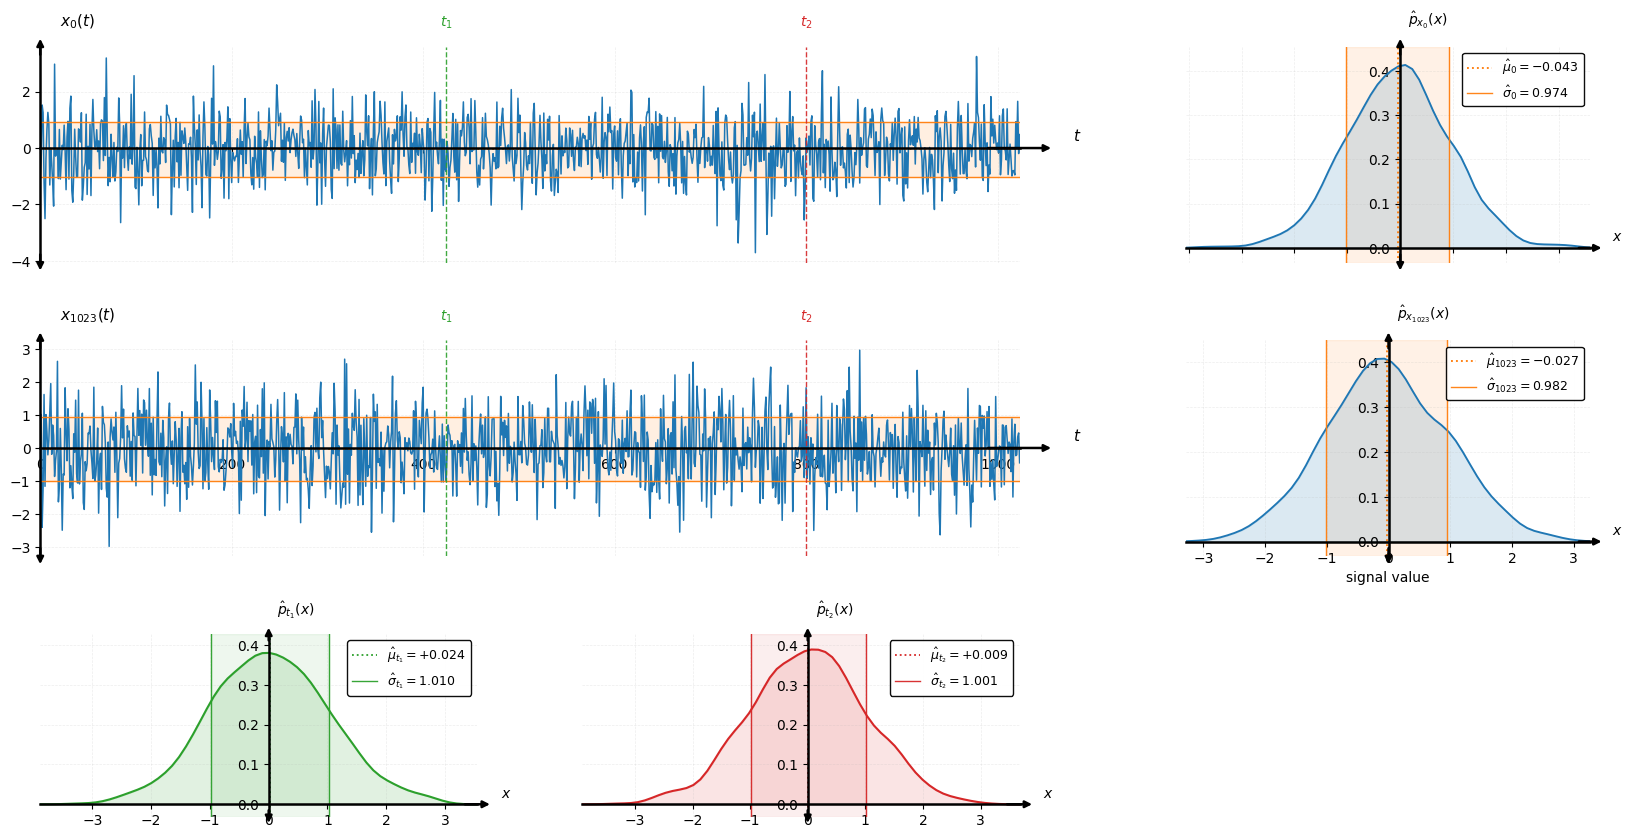

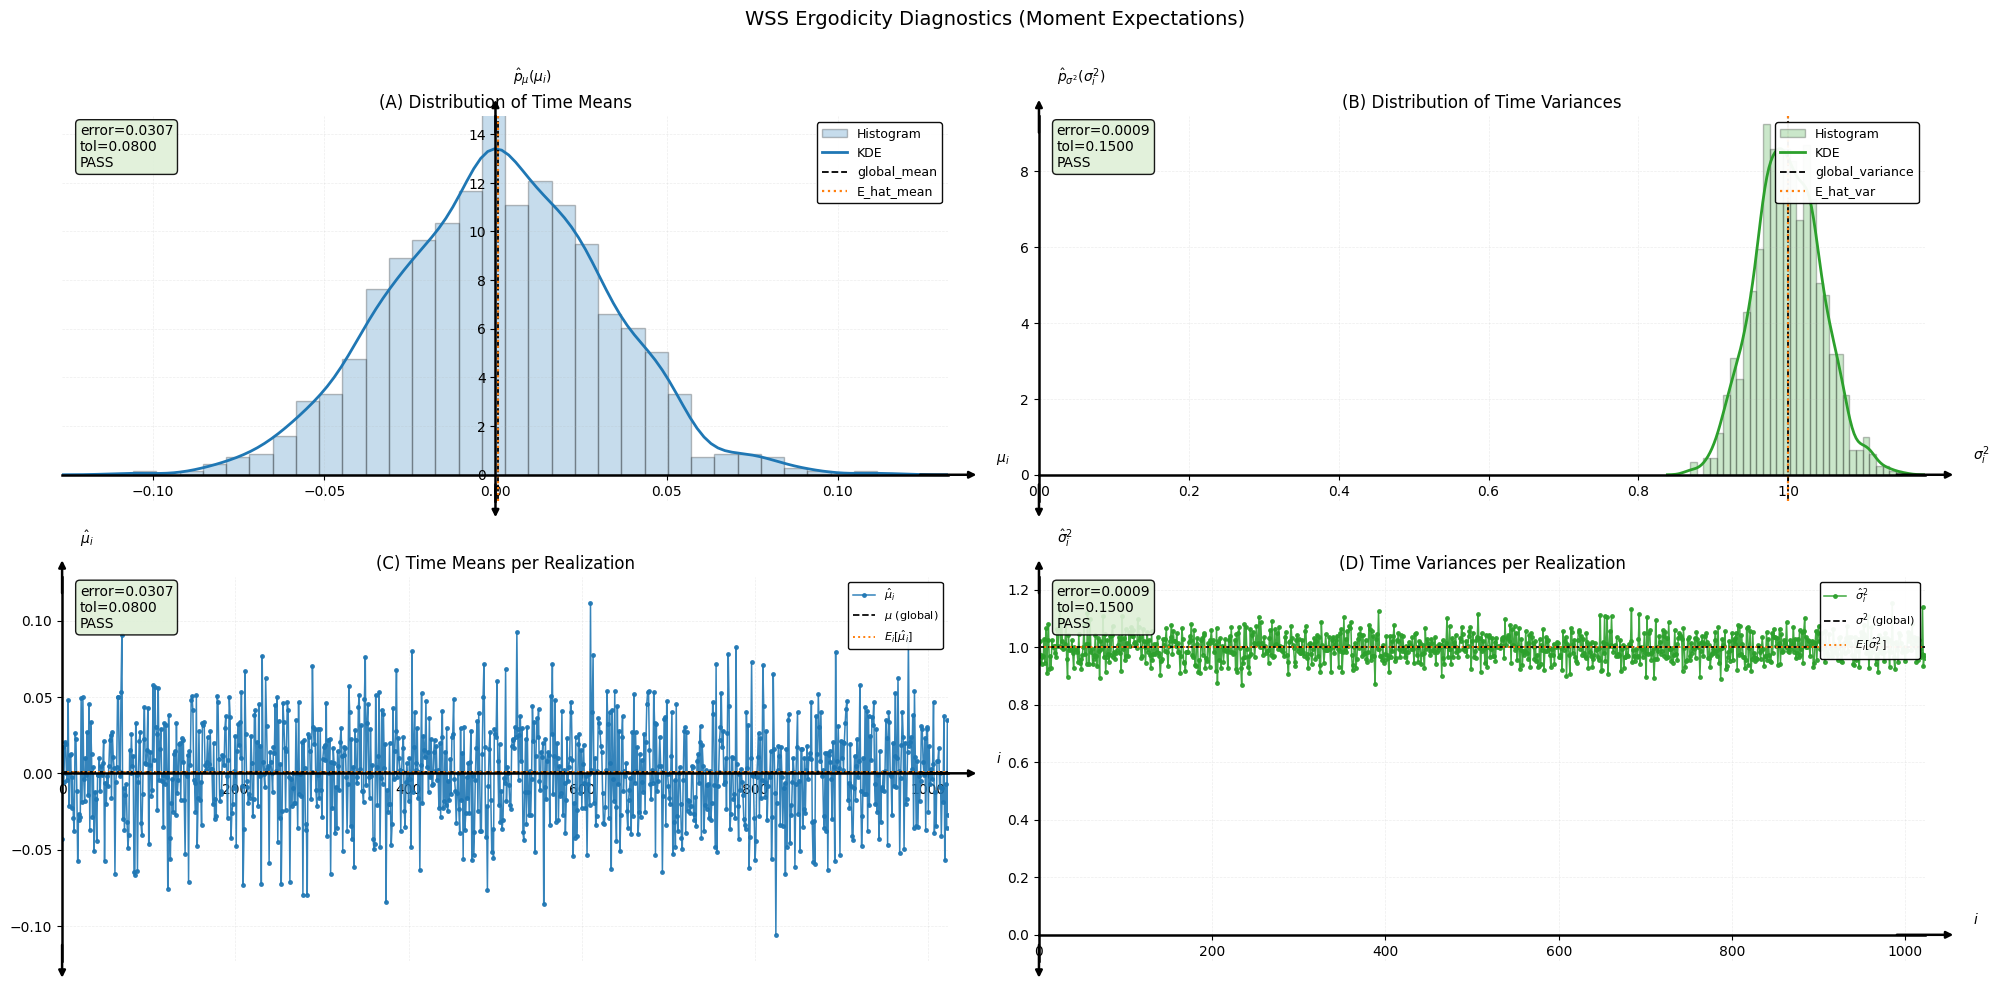

In [24]:
# EXAMPLE USAGE:

# Configure a reproducible ensemble for debugging.
num_realizations: int = 1024
num_samples: int = 1024
seed: int = 67

# Generate a WSS candidate process and visualize representative realizations.
signals_raw = get_random_signals(
    num_realizations=num_realizations,
    num_samples=num_samples,
    mean=0.0,
    std=1.0,
    seed=seed,
)

plot_realizations(signals_raw, realization_indices=[0, num_realizations - 1], seed=seed)

# Evaluate finite-sample WSS ergodicity from expected time moments on the same data.
ergodicity_report, ergodicity_fig = test_wss_ergodicity(
    signals_raw,
    mean_tolerance=0.08,
    wss_var_tolerance=0.15,
    make_plots=True,
    pdf_bins=128,
    kde_bandwidth=None,
    return_figure=True,
)

print(f"WSS ergodic decision:      {ergodicity_report['is_wss_ergodic']}")

plt.show()
